# Import libraries

In [1]:
import math
import pandas as pd
import numpy as np
from numpy import random as rnd

from tsad.evaluating.evaluating import evaluating #F1 score
from detecta import detect_cusum #CUMSUM

import matplotlib.pyplot as plt

import requests
from io import StringIO

from itertools import chain # list of list to one bit list
from collections import namedtuple 

import sys
sys.path.append(r'/home/gishb/PycharmProjects/Fedot.Industrial') #SST
from core.operation.transformation.WindowSelection import WindowSizeSelection
from core.models.detection.subspaces.SSTdetector import SingularSpectrumTransformation

from scipy.signal import butter, filtfilt
from optcutfreq import optcutfreq

from scipy.signal import savgol_filter

# Dataset

In [2]:
def df_expirement():
    url = "https://storage.yandexcloud.net/cloud-files-public/dataframe.csv" 
    df = pd.read_csv(StringIO(requests.get(url).content.decode('utf-8')), sep='|')
    return df

In [16]:
df = df_expirement()
df = df[df[df.columns[0]] == 'xxxAA684G'] #xxxAA684G xxxAA564G'

df.replace(['-9999', -9999,'missing','#'], np.nan, inplace=True)
df = df[df['unitless'].notna()]
df = df[df['uR/h'].notna()]
df = df.drop(axis=1, labels=(df.columns[0])) \
    .drop(axis=1, labels=(df.columns[1]))[['uR/h', 'unitless']].reset_index(drop=True)

In [17]:
#Create new columns for CPd and time
df['change_points'] = [1 if df['unitless'][i] !=  df['unitless'][i+1] else 0 for i in range(len(df)-1)] + [0]
df['time'] = np.arange(0, len(df)*1, 1).astype('datetime64[s]')
df = df.set_index('time')

# df['time'] = np.arange(0, len(df)*9, 9).astype('datetime64[s]')
# df = df.set_index('time')
df.head()

,uR/h,unitless,change_points
time,,,
1970-01-01 00:00:00,88.625,2.0,0
1970-01-01 00:00:01,107.250,2.0,0
1970-01-01 00:00:02,108.420,2.0,0
1970-01-01 00:00:03,109.590,2.0,0
1970-01-01 00:00:04,110.990,2.0,0


# Breef look at data

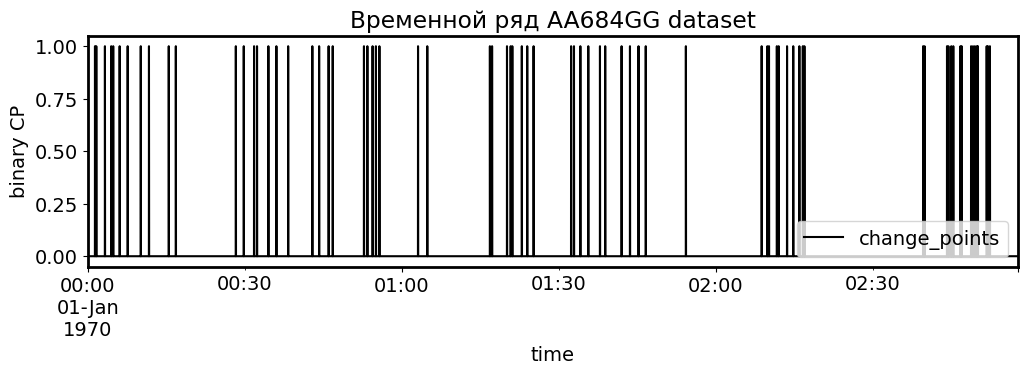

 Number CP: 74
 len data: 10664


In [18]:
df.change_points.plot(figsize=(12,3), color='black')
plt.legend(loc="lower right",)
plt.title('Временной ряд AA684GG dataset')
plt.ylabel('binary CP')
plt.show()
print(f' Number CP: {df[df["change_points"] == 1].count()[0]}')
print(f' len data: {df.count()[0]}')

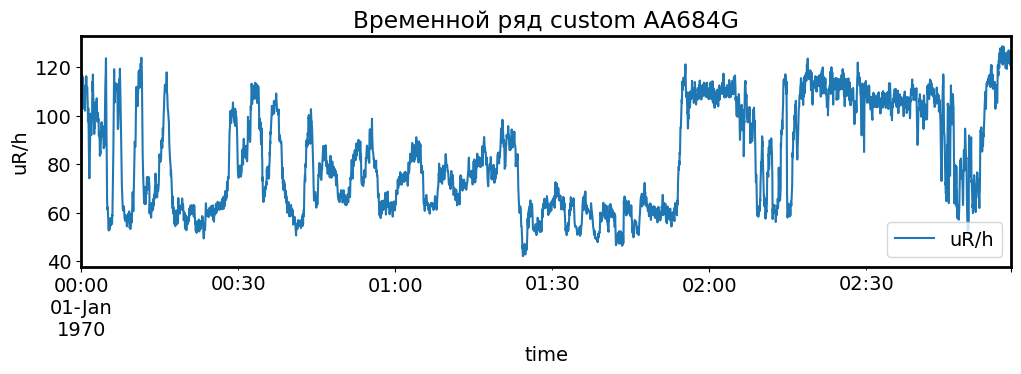

In [19]:
df['uR/h'].plot(figsize=(12,3))
plt.legend(loc="lower right")
plt.title('Временной ряд custom AA684G')
plt.ylabel('uR/h')
plt.show()

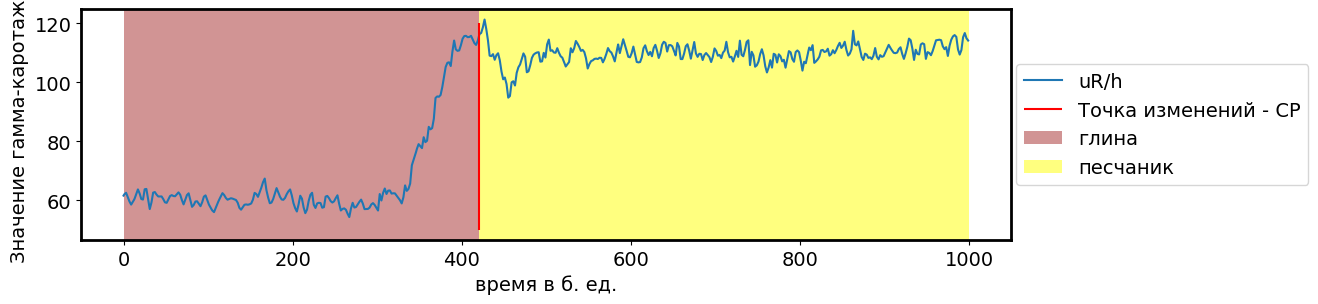

In [20]:
plt.figure(figsize=(12,3))
plt.plot(list(df['uR/h'][6500:7500]), label='uR/h')
plt.vlines(420, 50, 120, color='r', label='Точка изменений - CP')
plt.xlabel('время в б. ед.')
plt.ylabel('Значение гамма-каротажа')
plt.axvspan(0, 420, facecolor='brown', alpha=0.5, label='глина')
plt.axvspan(420, 1000, facecolor='yellow', alpha=0.5, label='песчаник')
plt.legend(loc="center right" , bbox_to_anchor=(1.33, 0.5))

# Kalman Filter block

In [21]:
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [22]:
def online_detection(time_series=list(), window=20, queue_window=10, treshold_coef=3):
    ''' 
        An online implementation of Kalman Filter Change Point Detection based on risiduals,
    and current time-series statistics for treshold updating.
    
    Note:
        queue_window - min possible distance between two predicted CPs.
        treshold_coef - if residuals above this treshold than we can detect CP. Based on np.meean + 3*np.std
        where 3 is the coef.
        window - the length of data which we save in memory.
    '''
    
    dp = [0]*window #массив с предсказаниями по CPs
    queue_risiduals = [0]*window #очередь с рядом остатков по которому отбивают трешхолд
    queue_cp = [0]*queue_window #очередь CPs
    queue_ts = time_series[:window] #р
    queue_gaussian = [gaussian(np.mean(queue_ts), np.var(queue_ts))]*2
    
    for i in range(window, len(time_series)): #Это цикл позволяет нам получать данные раз в 9 секунд условно.
        gaussian_likelihood = queue_gaussian[0] #смотрим начальное состояние MEAN VAR
        gaussian_prior = gaussian(np.mean(queue_ts), np.var(queue_ts)) #смотрим обновление состояние MEAN VAR

        x = update(gaussian_prior, gaussian_likelihood) #обновляем значение MEAN VAR
        queue_gaussian.pop(0) #удаляем старое значение
        queue_gaussian.append(gaussian_prior) #добавляем новое значение likelihood
        
        next_prediction = np.random.normal(loc=x.mean) #Генерируем значение исходя из нового знания об gaussian
        next_value = time_series[i] #П
        risidual_value = abs(next_prediction - next_value)
        
        mean_risidual_prev = np.mean(queue_risiduals)
        std_risidual_prev = np.std(queue_risiduals)
        queue_risiduals.pop(0) # удаляем старое значение risiduals
        queue_risiduals.append(risidual_value) #новое значение risiduals
        
        if risidual_value >= mean_risidual_prev + std_risidual_prev*treshold_coef: #проверка что мы нашли переход
            if max(queue_cp) != 1: #queue filter IF
                queue_cp.pop(0)
                queue_cp.append(1)
                dp.append(1)
            else: #queue filter else
                queue_cp.pop(0)
                queue_cp.append(0)
                dp.append(0)
        else:
                dp.append(0)
                queue_cp.pop(0)
                queue_cp.append(0)

        
        queue_ts.pop(0) #удаляем из очереди старое значение VALUE
        queue_ts.append(next_value) #добавляем в очередь новое значение VALUE
    return dp

In [23]:
cps_list = online_detection(list(df['uR/h']), window=51, queue_window=10, treshold_coef=4.2)
df['cps'] = cps_list

# Create report

In [24]:
def create_report(experiment_results: dict):
    experiment_df = pd.DataFrame.from_dict(experiment_results, orient='index')
    experiment_df = experiment_df.fillna(0)
    return experiment_df

def tsad_average(predicted_list, original_list):
    averate_time, missed_cp, FPs, true_anomalies = evaluating(original_list, predicted_list, metric='average_time', numenta_time='30 sec', verbose=False)
    TP = true_anomalies - missed_cp
    precision = TP/(TP+FPs)
    recall = TP/(TP+missed_cp)
    if precision == 0 or recall ==0:
        F1 = 0
    else:
        F1 = 2*precision*recall/(precision+recall)
    return {'Time_Delta': averate_time, 'Missed_CP': missed_cp, 'FPs': FPs, 'True_Anomalies_Count': true_anomalies, 'precision':precision, 'recall':recall,'F1':F1}

def tsad_nab(predicted_list, original_list):
    nab = evaluating(original_list, predicted_list, metric='nab', numenta_time='30 sec', verbose=False)
    return nab

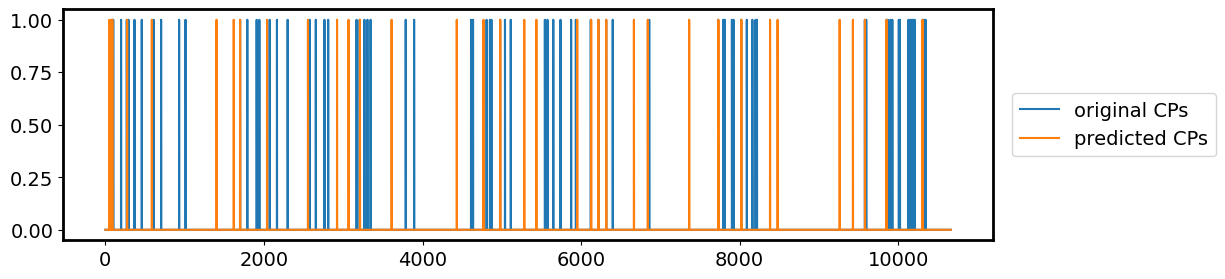

In [25]:
plt.figure(figsize=(12,3))
plt.plot(list(df.change_points), label='original CPs')
plt.plot(cps_list,label='predicted CPs')
plt.legend(loc="center right" , bbox_to_anchor=(1.25, 0.5))

In [26]:
%%capture --no-display
tsad_average_results = tsad_average(df.cps, df.change_points)

In [27]:
%%capture --no-display
tsad_nab_results = tsad_nab(df.cps, df.change_points)

In [28]:
tsad_nab_results.update(tsad_average_results)
create_report(tsad_nab_results)

,0
Standart,8.79
LowFP,6.58
LowFN,10.81
Time_Delta,0 days 00:00:10.818181818
Missed_CP,63
FPs,24
True_Anomalies_Count,74
precision,0.314286
recall,0.148649
F1,0.201835
